## **IMPORTACIÓN DE LIBRERIAS, DEFINICIÓN DE CAPAS DEL MODELO Y DEFINIR CLASE ASOCIADA A LOS DATOS**


In [1]:

import tensorflow as tf
import glob
import random
import tensorflow.keras.layers as layers
import numpy as np
from skimage.io import imread
import os
import matplotlib.pyplot as plt
import cv2
from datetime import datetime
from packaging import version
import datetime
from tensorboard.plugins.hparams import api as hp



tf.debugging.set_log_device_placement(True)


#Detecting GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


def unet():
  inputs = tf.keras.Input((112, 112, 3))

  # Entry block
  x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x  # Set aside residual

  # Blocks 1, 2, 3 are identical apart from the feature depth.
  for filters in [64, 128, 256]:
      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(filters, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(filters, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

      # Project residual
      residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
          previous_block_activation
      )
      x = layers.add([x, residual])  # Add back residual
      previous_block_activation = x  # Set aside next residual

  ### [Second half of the network: upsampling inputs] ###

  for filters in [256, 128, 64, 32]:
      x = layers.Activation("relu")(x)
      x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.Activation("relu")(x)
      x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.UpSampling2D(2)(x)

      # Project residual
      residual = layers.UpSampling2D(2)(previous_block_activation)
      residual = layers.Conv2D(filters, 1, padding="same")(residual)
      x = layers.add([x, residual])  # Add back residual
      previous_block_activation = x  # Set aside next residual

  # Add a per-pixel classification layer
  outputs = layers.Conv2D(1, (1, 1), activation='sigmoid') (x)

  # Define the model
  model = tf.keras.Model(inputs, outputs)
  return model



class data(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            x[j] = plt.imread(path)
        y = np.zeros((self.batch_size,) + self.img_size , dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = plt.imread(path)
            y[j] = img
        return x, y


Num GPUs Available:  1


# **IMPORTACIÓN DE DATOS Y DIVISIÓN DE ENTRENAMIENTO Y PRUEBA**

In [2]:

    #Impoting data

img_files = glob.glob('DATA/frames/*.png')
mask_files = [glob.glob('DATA/masks/' + os.path.basename(im))[0] for im in img_files]
N =  2000#len (img_files)

# Spliting data 

ixRand  = list(range(N))
random.shuffle(ixRand)
train_data = [img_files[e] for e in ixRand[:round(N*.8)]]
train_labels = [mask_files[e] for e in ixRand[:round(N*.8)]]

test_data = [img_files[e] for e in ixRand[round(N*.8):]]
test_labels = [mask_files[e] for e in ixRand[round(N*.8):]]

# torch needs that data comes from an instance with getitem and len methods (Map-style datasets)

training_dataset = data(32,(112,112), train_data, train_labels)

val_dataset = data(32,(112,112), test_data, test_labels)

# **Instanciar modelo con función de perdida (entropía cruzada) y optimizador adam**

In [3]:


model = unet()
model.compile(optimizer='adam',
               loss='binary_crossentropy',
              metrics=['accuracy'])

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/d

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/d

Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replic

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /

In [4]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 56, 56, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 56, 56, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# **Entrenamiento de los lotes**

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVari

/home/alan/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in d

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/repli

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:loc

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhos

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/repli

48/50 [===========================>..] - ETA: 0s - loss: 0.4144 - accuracy: 0.9343Executing op __inference_train_function_5047 in device /job:localhost/replica:0/task:0/device:GPU:0


50/50 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.9355Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Model

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

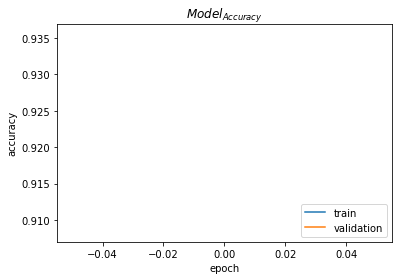

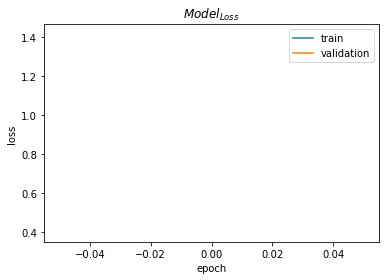

In [4]:

from datetime import date
import time

start = time.time()
logs = "logs/" + date.today().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

# Train the model, doing validation at the end of each epoch.
epochs = 1
history = model.fit(training_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[tboard_callback])
#%%
end = time.time()
elapsed = (end - start)
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('$Model_{Accuracy}$')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('$Model_{Loss}$') 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()



# **Mostrar algunos resultados de predicción**


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executin

Executing op __inference_predict_function_24552 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_24552 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_24552 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_24552 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_24552 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_24552 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_24552 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_24552 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_24552 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_24552 in device /job:localhost/

Text(0.5, 1.0, 'Ground trouth')

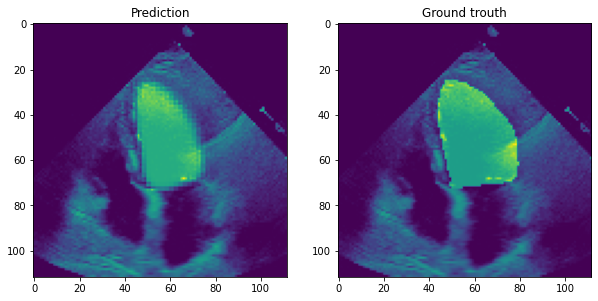

In [16]:
pred = model.predict(val_dataset)
savePred = [cv2.imwrite('DATA/pred/' +  os.path.basename(test_data[i]),  np.squeeze(np.array(pred[i]>.5, dtype='uint8'),-1) *255) for i in range (len(pred))]
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(np.squeeze(pred[6,:,:,:],-1) + cv2.cvtColor(plt.imread(test_data[6]), cv2.COLOR_BGR2GRAY))
plt.title('Prediction')
plt.subplot(122)
plt.imshow( cv2.cvtColor(plt.imread(test_data[6]), cv2.COLOR_BGR2GRAY) + plt.imread(test_labels[6]))
plt.title('Ground trouth')

In [17]:
pip install -U tensorboard-plugin-profile


Note: you may need to restart the kernel to use updated packages.


In [40]:
!kill 11064

In [7]:
pip install -U tensorboard-plugin-profile


  Using cached tensorboard_plugin_profile-2.4.0-py3-none-any.whl (1.2 MB)
  Using cached gviz_api-1.9.0-py2.py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Load the TensorBoard notebook extension.
%reload_ext tensorboard

# Launch TensorBoard and navigate to the Profile tab to view performance profile
%tensorboard --logdir=logs
